# Contraejemplo rank 1

Veremos una red de 3 barras en la que la solución al ACOPF relajado da lugar a una matriz que no es de rango 1. La red es tomada del artículo:


[B. C. Lesieutre, D. K. Molzahn, A. R. Borden and C. L. DeMarco, "Examining the limits of the application of semidefinite programming to power flow problems," (2011, Allerton)](https://drive.google.com/open?id=1JC1m_Sscx_wkMigO3LiNNdcqwTkX8yz3)



In [1]:
# Importar paquetes
import cvxpy as cp
import numpy as np
from matplotlib import pyplot as plt

![Red Ejemplo](red_ejemplo.png)

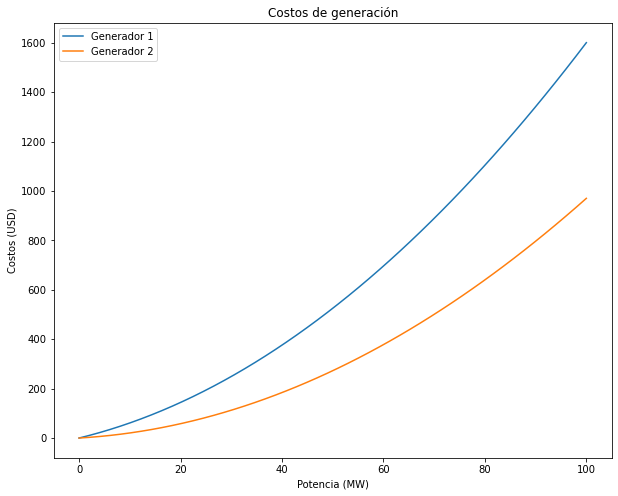

In [2]:
cg1 = [5, .11]
cg2 = [1.2, .085]

g = np.linspace(0,100)

c1 = cg1[0]*g+cg1[1]*g**2
c2 = cg2[0]*g+cg2[1]*g**2

plt.figure(figsize=(10,8))
plt.plot(g, c1, label='Generador 1')
plt.plot(g, c2, label='Generador 2')
plt.title('Costos de generación')
plt.xlabel('Potencia (MW)')
plt.ylabel('Costos (USD)')
plt.legend()
plt.show()



**Restricciones**
- G3 compensa reactiva
- La línea 2, que conecta las barras 2 y 3 tiene restricción en potencia aparente.

In [3]:
# --------------------------
# Crear matriz de admitancia
# --------------------------
# Matriz de incidencia
A = np.array([[1, 0, -1],
              [0, -1, 1],
              [1, -1, 0]])

# Reactancias en pu
# (1,3), (3,2), (2,1)
b = np.array([0.45, 0.7, 0.3])
Z = np.diag([0.065+1j*0.620, 0.025+1j*0.750, 0.042+1j*0.900])
H = np.linalg.inv(Z)@A

Y = A.transpose()@H
Y = np.array(Y)

# Agregar capacitancias shunt
Y[0,0] += .5j*(b[0] + b[2]) # Linea 1
Y[1,1] += .5j*(b[2] + b[1]) # Linea 2
Y[2,2] += .5j*(b[1] + b[0]) # Linea 3


# ----------------------------
# Caracteristicas del problema
# ----------------------------
Sbase = 100 # MVA
d = np.array([110+40j, 110+40j, 95+50j]) / Sbase # demanda

# costos de generacion
c1 = np.array([5, 1.2, 0])
c2 = np.array([0.11, 0.085, 0])



# --------------------------
# Crear matrices hermiticas
# --------------------------

# Balance de cada nodo
# --------------------
E = np.zeros([3,3,3])
y = np.zeros([3,3,3], dtype=np.complex64)
Phi = np.zeros([3,3,3], dtype=np.complex64)
Psi = np.zeros([3,3,3], dtype=np.complex64)
                                  

for k in range(0,3):
  E[k,k,k] = 1 # Todo ceros salvo en el kk-esimo elemento
  y[k] = E[k] @ Y # y[k] tiene en su k-esima fila la k-esima fila de Y
  Phi[k] = .5 * (np.matrix(y[k]) + np.matrix(y[k]).H) 
  Psi[k] = .5 /(1j) * (-np.matrix(y[k]) + np.matrix(y[k]).H)



# Restricciones en las líneas
# ---------------------------
ek = [[1,0,0], # linea 1 sale de barra 1
      [0,0,1],
      [1,0,0]]
# Matrices de restricciones en las lineas
M = np.zeros([3,3,3], dtype=np.complex64)                 
N = np.zeros([3,3,3], dtype=np.complex64)


Yki = np.zeros([3,3])


for l in range(0,3):
  Yki = 1/Z[l,l] * np.outer(ek[l], A[l]) + .5j*b[l]*np.outer(ek[l], ek[l])
  Yki_aster = np.matrix(Yki).H
  M[l] = .5 * (np.matrix(Yki_aster) + np.matrix(Yki_aster).H)  
  N[l] = .5 * (np.matrix(Yki_aster) - np.matrix(Yki_aster).H) / 1j



  
  
# ------------------
# Variables de CVXPY
# ------------------
pb = cp.Variable(3) # potencia activa neta inyectada en las barras = g - Re(d)
qb = cp.Variable(3) # potencia reactiva neta inyectada en las barras = q - Im(d)
g = cp.Variable(3) # potencia de cada generador 
q = cp.Variable(3) # potencia reactiva de cada generador 
pl = cp.Variable(3) # potencia activa por las líneas
ql = cp.Variable(3) # potencia activa por las líneas


W = cp.Variable((3,3), hermitian=True) # Matriz hermitica, (con suerte) Rank=1

cost = (c1*g+cp.quad_form(g,np.diag(c2)))
constraints = [pb == g - cp.real(d), qb == q - cp.imag(d), g >= 0, g[2] == 0, W>>0]


# Balance por nodo
for k in range(0,3):
  Phir = np.real(Phi[k])
  Phii = np.imag(Phi[k])
  Psir = np.real(Psi[k])
  Psii = np.imag(Psi[k])
  #la siguiente línea implementa traza(Phi*W)=pb[k]
  constraints.append(cp.trace(Phir*cp.real(W) - Phii*cp.imag(W)) == pb[k])
  #constraints.append(cp.trace(Phir*X - Phii*Y) == pb[k])
  constraints.append(cp.trace(Psir*cp.real(W) - Psii*cp.imag(W)) == qb[k])
  

#Restricciones de linea
for l in range(0,3):
  Mr = np.real(M[l])
  Mi = np.imag(M[l])
  Nr = np.real(N[l])
  Ni = np.imag(N[l])
  constraints.append(cp.trace(Mr*cp.real(W) - Mi*cp.imag(W)) == pl[l])
  constraints.append(cp.trace(Nr*cp.real(W) - Ni*cp.imag(W)) == ql[l])

constraints.append(pl[1]**2+ql[1]**2 <= (40/Sbase)**2)
# for k in range(0,5):
#   constraints.append(cp.trace(E[k]*X)<=1.1)
#   constraints.append(cp.trace(E[k]*X)>=.9)  
  
# Restricciones de tension
constraints.append(cp.diag(cp.real(W))<=1.1**2)
constraints.append(cp.diag(cp.real(W))>=.9**2)

prob = cp.Problem(cp.Minimize(cost),constraints)

prob.solve(max_iters = 10000, verbose=False) #Poniendo verbose=False se oculta el Solver

print('CVXPY\n-----')

print('Solución:', prob.status)



# Inyeccion de reactiva
# Transporte de reactiva (lineas)
#ql = np.zeros(3)
#for k in range(0,3):
#  ql[k] = np.trace(N[k] @ W.value)

# ------------------
# MOSTRAR RESULTADOS
# ------------------
np.set_printoptions(precision=7)
np.set_printoptions(suppress=True)
print()
print()
print('RESULTADOS:')
print('----------')
print("El costo óptimo es", prob.value*100)
print()
print('Generacion activa optima', g.value*100)
print('Generacion reactiva optima', q.value*100)

print("Inyeccion P", pb.value*100)
print('Inyeccion Q', qb.value*100)

print('\n------')
print('Lineas')
print('------')
print('P:', pl.value*100)
print('Q:', ql.value*100)
print('S:', 100*np.sqrt(pl.value**2+ql.value**2))

  


#print('Multiplicadores de Lagrange:')
#for k in range(0,7):
#  print(constraints[k].dual_value)
#print(np.allclose(W.value,np.matrix(W.value).H))
#print(W.value)
print('')
print('-------------------')
print('Checkeo: W rango 1:')
print('-------------------')


print('Valores propios de W:')
vapW, eigW = np.linalg.eig(W.value)
print('Valores propios',vapW)

print('Cociente entre maximo y minimo valor propio no nulo:')
print(np.abs(vapW[0]/vapW[1]))




z=np.where(np.abs(vapW)>1e-2)

#print('Unico valor propio no nulo:')
#print(vapW[z])



voltaje = eigW[:,0]*np.sqrt(vapW[0])
voltaje_modulo = np.abs(voltaje)
tita = np.angle(voltaje)*180/np.pi # Pasaje a grados

print('\n---------\nTensiones\n---------')
print('Barra\t V(pu)\t Angulo(grados)')
for i in range(0,3):
  print(i,'\t','%.3f'%voltaje_modulo[i],'\t','%.3f'%tita[i])
  
  
# Perdidas en las lineas
p_loss = np.zeros(3)
q_loss = np.zeros(3)

D = [(2,2), (2,2), (1,1)] # Linea 1 conecta (1>3), Linea 2 (3>2),...

ei = [[0,0,1], # linea 1 sale de barra 1
      [0,1,0],
      [0,1,0]]
# Matrices de restricciones en las lineas
Mik = np.zeros([3,3,3], dtype=np.complex64)                 
Nik = np.zeros([3,3,3], dtype=np.complex64)
Yik = np.zeros([3,3])


for l in range(0,3):
  Yik = 1/Z[l,l] * np.outer(ei[l], -A[l]) + .5j*b[l]*np.outer(ek[l], ek[l])
  Yik_aster = np.matrix(Yik).H
  Mik[l] = .5 * (np.matrix(Yik_aster) + np.matrix(Yik_aster).H)  
  Nik[l] = .5 * (np.matrix(Yik_aster) - np.matrix(Yik_aster).H) / 1j
  p_loss[l] = np.real(np.trace( (M[l] + Mik[l]) @ W.value))
  q_loss[l] = np.real(np.trace( (N[l] + Nik[l]) @ W.value))

print('\n----------------------')
print('Pérdidas en las líneas')
print('----------------------')
print('Activa:', p_loss*100)
print('Reactiva:', q_loss*100)



CVXPY
-----
Solución: optimal


RESULTADOS:
----------
El costo óptimo es 888.9682380157469

Generacion activa optima [112.1598746 225.8171465   0.0005608]
Generacion reactiva optima [149.6631421 135.6632655  77.1917598]
Inyeccion P [  2.1624277 115.8194026 -94.9978927]
Inyeccion Q [109.663574   95.6637041  27.1923217]

------
Lineas
------
P: [ 69.3046973 -37.9373509 -67.140867 ]
Q: [56.7807455 12.6787046 52.8828788]
S: [89.59461   39.9999018 85.4663378]

-------------------
Checkeo: W rango 1:
-------------------
Valores propios de W:
Valores propios [2.5364083+0.j 0.0000071-0.j 0.6935684-0.j]
Cociente entre maximo y minimo valor propio no nulo:
357163.3380769109

---------
Tensiones
---------
Barra	 V(pu)	 Angulo(grados)
0 	 1.026 	 0.000
1 	 0.970 	 36.546
2 	 0.736 	 -14.538

----------------------
Pérdidas en las líneas
----------------------
Activa: [12.2395215  4.4237806  6.3237927]
Reactiva: [62.2976988 76.0140801 99.2108477]


a) Reflexionar sobre qué sucedería si se modificaran los costos de generación y luego correr el problema con nuevos costos.

b) Reflexionar sobre qué sucedería si se modificaran los límites de las líneas y luego correr el problema con nuevos costos.

